In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/11.1.0'

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import haiku as hk
import jax
import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial

import tensorflow as tf
import tensorflow_datasets as tfds

from jax_lensing.inversion import ks93inv, ks93

from jax_lensing.spectral import measure_power_spectrum, make_power_map

from astropy.io import fits

from tqdm.notebook import tqdm

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Times"]})

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["mathtext.fontset"] = "cm"

In [5]:
resolution = 0.29
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
map_size = 360
gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
sigma_gamma = .148

ps_data = onp.load(gaussian_path).astype('float32')
ell = jnp.array(ps_data[0,:])
ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2) # normalisation by pixel size
kell = ell /2/jnp.pi * 360 * pixel_size / map_size

# Interpolate the Power Spectrum in Fourier Space
ps_map = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))

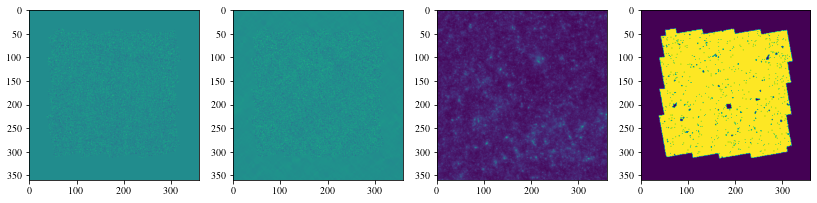

In [6]:
mask = fits.getdata('../../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

convergence = fits.getdata('../../data/ktng/ktng_kappa360v2.fits').astype('float32')
meas_shear = jnp.stack(ks93inv(convergence, jnp.zeros_like(convergence)), axis=-1)
std1 = fits.getdata('../../data/COSMOS/std1.fits').astype('float32').reshape((360,360,1))
std2 = fits.getdata('../../data/COSMOS/std2.fits').astype('float32').reshape((360,360,1))
sigma_gamma = jnp.concatenate([std1, std2], axis=-1)
meas_shear += sigma_gamma * jax.random.normal(jax.random.PRNGKey(0), meas_shear.shape)
#meas_shear += 0.148*np.random.randn(360,360,2)

mask = jnp.expand_dims(mask, -1)
sigma_mask = (1-mask)*1e10

masked_true_shear = meas_shear*mask

figure(figsize(14,5))
subplot(141)
imshow(masked_true_shear[..., 0])
subplot(142)
imshow(meas_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask[...,0])

In [7]:
def log_gaussian_prior(map_data, sigma, ps_map):
    map_data = map_data.reshape(360, 360)
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [8]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros(ke.shape)
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    return - jnp.sum((model_shear - masked_true_shear)**2/((sigma_gamma)**2 + sigma**2 + sigma_mask) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

In [9]:
def total_score_fn(x, sigma):
    """ Compute the total score, combining the following components:
        gaussian prior, ml prior, data likelihood
    """
    data_score = likelihood_score(x, sigma, meas_shear, mask)
    gaussian_score = gaussian_prior_score(x, sigma, ps_map)
    return (data_score + gaussian_score).reshape(-1, 360*360)

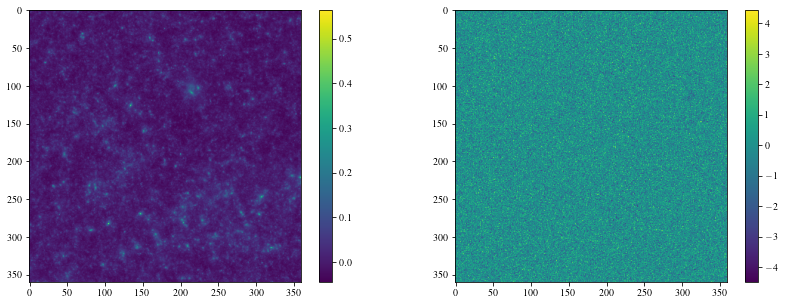

In [10]:
import numpy as onp
kappa_init = onp.random.randn(map_size, map_size) * 1.
sigma = jnp.zeros((1,1,1))

# Initialize with KS93
subplot(121)
imshow(convergence)
colorbar()
subplot(122)
imshow(kappa_init)
colorbar()

kappa_init = jnp.expand_dims(kappa_init, axis=0)

In [11]:
# compute MAP update
eps = 1e-5

@jax.jit
def update(x_old):
    gradient = total_score_fn(x_old, sigma)
    print(gradient)
    x_new = x_old + eps * gradient.reshape(1, 360, 360)
    return x_new

In [12]:
x_old = kappa_init.copy()
loss = []
samples = []

n_steps = 20000

for i in tqdm(range(n_steps)):
    x_new = update(x_old)
    samples.append(x_new)
    x_old = x_new
    
convergence_MAP = x_new[0,...]

  0%|          | 0/20000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[1,129600])>with<DynamicJaxprTrace(level=0/1)>


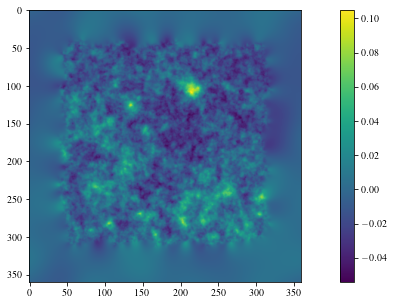

In [13]:
imshow(convergence_MAP)
colorbar()

In [14]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from jax_lensing.samplers.score_samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from jax_lensing.samplers.tempered_sampling import TemperedMC

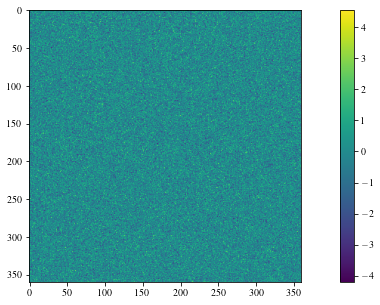

In [15]:
import numpy as onp

batch_size = 3

initial_temperature = 1.
initial_step_size = 0.013 #0.013
min_steps_per_temp = 10

init_image, _ = ks93(mask[...,0]*masked_true_shear[...,0], mask[...,0]*masked_true_shear[...,1])
init_image = jnp.expand_dims(init_image, axis=0)
init_image = jnp.repeat(init_image, batch_size, axis=0)

init_image += (initial_temperature*onp.random.randn(batch_size,360,360))


imshow(init_image[2,...].reshape(360, 360))
colorbar()

## ODE sampler

In [16]:
# HMC up to 1e-3, then ODE sampler
sol0 = np.load('../../scripts/tests/data/denoised_0.npy')
sol1 = np.load('../../scripts/tests/data/denoised_1.npy')
sol2 = np.load('../../scripts/tests/data/denoised_2.npy')
sol3 = np.load('../../scripts/tests/data/denoised_3.npy')
sol4 = np.load('../../scripts/tests/data/denoised_4.npy')
sol5 = np.load('../../scripts/tests/data/denoised_5.npy')
sol6 = np.load('../../scripts/tests/data/denoised_6.npy')
sol7 = np.load('../../scripts/tests/data/denoised_7.npy')
sol8 = np.load('../../scripts/tests/data/denoised_8.npy')
sol9 = np.load('../../scripts/tests/data/denoised_9.npy')
sol10 = np.load('../../scripts/tests/data/denoised_10.npy')
sol11 = np.load('../../scripts/tests/data/denoised_11.npy')
sol12 = np.load('../../scripts/tests/data/denoised_12.npy')
sol13 = np.load('../../scripts/tests/data/denoised_13.npy')
sol14 = np.load('../../scripts/tests/data/denoised_14.npy')
sol15 = np.load('../../scripts/tests/data/denoised_15.npy')
sol16 = np.load('../../scripts/tests/data/denoised_16.npy')
sol17 = np.load('../../scripts/tests/data/denoised_17.npy')
sol18 = np.load('../../scripts/tests/data/denoised_18.npy')
sol19 = np.load('../../scripts/tests/data/denoised_19.npy')
sol20 = np.load('../../scripts/tests/data/denoised_20.npy')
sol21 = np.load('../../scripts/tests/data/denoised_21.npy')
sol22 = np.load('../../scripts/tests/data/denoised_22.npy')
sol23 = np.load('../../scripts/tests/data/denoised_23.npy')
sol24 = np.load('../../scripts/tests/data/denoised_24.npy')
sol25 = np.load('../../scripts/tests/data/denoised_25.npy')
sol26 = np.load('../../scripts/tests/data/denoised_26.npy')
sol27 = np.load('../../scripts/tests/data/denoised_27.npy')
sol28 = np.load('../../scripts/tests/data/denoised_28.npy')
solprev = denoisedprev = np.concatenate([sol0, sol1, sol2, sol3, sol4, sol5, sol6, sol7, sol8,
                                         sol9, sol10, sol11, sol12, sol13, sol14, sol15, sol16,
                                         sol17, sol18, sol19, sol20, sol21, sol22, sol23,
                                         sol24, sol25, sol26, sol27, sol28,], axis=0)

# HMC up to 1e-4
sol0 = np.load('../../results/gaussian/samples_lowertemp_longer_1.npy')
sol1 = np.load('../../results/gaussian/samples_lowertemp_longer_2.npy')
sol2 = np.load('../../results/gaussian/samples_lowertemp_longer_3.npy')
sol3 = np.load('../../results/gaussian/samples_lowertemp_longer_4.npy')
sol4 = np.load('../../results/gaussian/samples_lowertemp_longer_5.npy')
sol5 = np.load('../../results/gaussian/samples_lowertemp_longer_6.npy')
sol6 = np.load('../../results/gaussian/samples_lowertemp_longer_7.npy')
sol7 = np.load('../../results/gaussian/samples_lowertemp_longer_8.npy')
sol8 = np.load('../../results/gaussian/samples_lowertemp_longer_9.npy')
sol9 = np.load('../../results/gaussian/samples_lowertemp_longer_10.npy')
sol10 = np.load('../../results/gaussian/samples_lowertemp_longer_11.npy')
sol11 = np.load('../../results/gaussian/samples_lowertemp_longer_12.npy')
sol12 = np.load('../../results/gaussian/samples_lowertemp_longer_13.npy')
sol13 = np.load('../../results/gaussian/samples_lowertemp_longer_14.npy')
sol14 = np.load('../../results/gaussian/samples_lowertemp_longer_15.npy')
sol15 = np.load('../../results/gaussian/samples_lowertemp_longer_16.npy')
sol16 = np.load('../../results/gaussian/samples_lowertemp_longer_17.npy')
sol17 = np.load('../../results/gaussian/samples_lowertemp_longer_18.npy')
sol18 = np.load('../../results/gaussian/samples_lowertemp_longer_19.npy')
sol19 = np.load('../../results/gaussian/samples_lowertemp_longer_20.npy')
sol20 = np.load('../../results/gaussian/samples_lowertemp_longer_21.npy')
sol21 = np.load('../../results/gaussian/samples_lowertemp_longer_22.npy')
sol22 = np.load('../../results/gaussian/samples_lowertemp_longer_23.npy')
sol23 = np.load('../../results/gaussian/samples_lowertemp_longer_24.npy')
sol24 = np.load('../../results/gaussian/samples_lowertemp_longer_25.npy')
sol = denoised = np.concatenate([sol0, sol1, sol2, sol3, sol4, sol5, 
                                 sol6, sol7, sol8, sol9, sol10, sol11, 
                                 sol12, sol13, sol14, sol15, sol16, sol17,
                                 sol18, sol19, sol20, sol21, sol22, sol23, sol24], axis=0)

In [17]:
solprev.shape

(2101, 360, 360)

In [18]:
#np.save('../../results/gaussian/samples_denoised_10.npy', denoised)

## Wiener Solution
Messenger Field algorithm

In [19]:
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import gc
import jax, sys
import importlib
from jax.ops import index, index_add, index_update

In [20]:
from jax_lensing import wiener_sampling, spectral, inversion

In [21]:
from astropy.io import fits
from jax_lensing.inversion import ks93inv

In [22]:
mask = mask[...,0]

In [23]:
test_kappa = convergence
test_e = masked_true_shear
ps_ktng_th = jnp.load("../../data/ktng/ktng_PS_theory.npy").astype('float32')

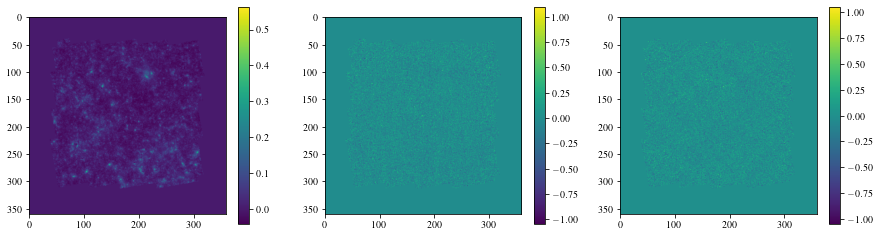

In [24]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa*mask), plt.colorbar()
_ = plt.subplot(132), plt.imshow(test_e[:,:,0]), plt.colorbar()
_ = plt.subplot(133), plt.imshow(test_e[:,:,1]), plt.colorbar()

In [25]:
std_e1 = 0.148
#ncov_diag_e1 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e10
#ncov_diag_e2 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e10
ncov_diag_e1 = np.ones(test_kappa.shape)*std1[...,0]*std1[...,0]*mask + np.abs(1.-mask)*1e10
ncov_diag_e2 = np.ones(test_kappa.shape)*std2[...,0]*std2[...,0]*mask + np.abs(1.-mask)*1e10

In [26]:
resolution = 0.29 # arcmin/pixel
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

In [27]:
k_map, ps_map = spectral.measure_power_spectrum(test_kappa+1j*test_kappa*0., pixel_size)
k_map = index_update(k_map, index[0], 0.)
ps_map = index_update(ps_map, index[128:], 0.)

k_map = k_map / 2 / jnp.pi * pixel_size * 360
ps_map = ps_map / pixel_size**2

In [28]:
kell = ps_ktng_th[0,:] / 2 / jnp.pi * pixel_size * 360
ps_th = ps_ktng_th[1,:] / pixel_size**2

k = np.arange(k_map.shape[0])
ps_th_interp = jnp.interp(k, kell, ps_th)
ps_th_interp = index_update(ps_th_interp, index[0], 0.)
ps_th_interp = index_update(ps_th_interp, index[128:], 0.)

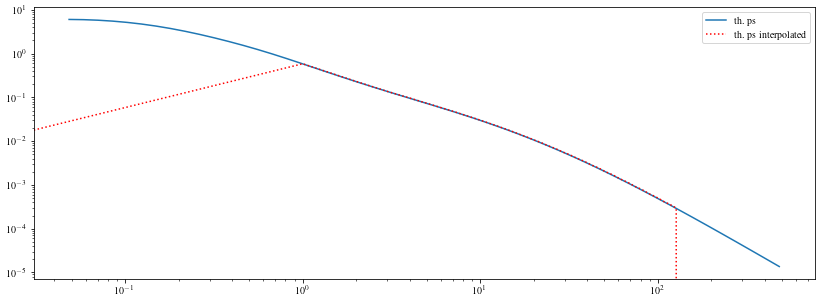

In [29]:
#plt.loglog(k_map, ps_map, '--', label='ps from map')
plt.loglog(kell, ps_th, label='th. ps')
plt.loglog(ps_th_interp, ':', color='red', label='th. ps interpolated')
plt.legend()

In [30]:
ps_th_map = jnp.fft.fftshift(spectral.make_power_map(ps_th_interp,360))
ps_th_map = index_update(ps_th_map, index[180,180], 0.)

In [31]:
# Use the thoertical Power Spectrum
ps_map = ps_th_map

In [32]:
%%time
wf_e1, wf_e2 = wiener_sampling.spin_wiener_filter_jit(test_e[:,:,0]+1j*test_kappa*0.,
                                                      test_e[:,:,1]+1j*test_kappa*0.,
                                                      ncov_diag_e1,
                                                      ncov_diag_e2,
                                                      ps_map,
                                                      ps_map*0.,
                                                      iterations=20)
wf_e, wf_b = inversion.ks93(wf_e1, wf_e2)

CPU times: user 812 ms, sys: 15.4 ms, total: 827 ms
Wall time: 494 ms


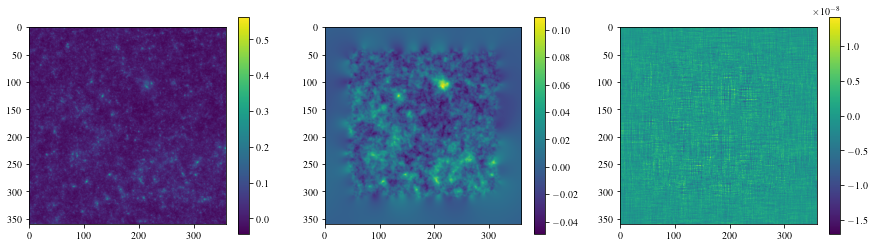

In [33]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_e), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_b), plt.colorbar()

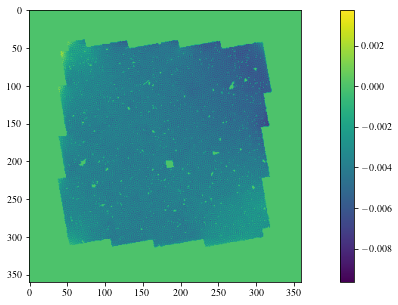

In [34]:
imshow(mask*(convergence_MAP-wf_e))
colorbar()

In [35]:
print(denoisedprev.shape)
print(denoised.shape)

(2101, 360, 360)
(1550, 360, 360)


In [36]:
resolution = 0.29 # arcmin/pixel
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel

nsm_map = convergence_MAP
kp = convergence

gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
ps_data_th = np.load(gaussian_path).astype('float32')

k_wiener, ps_wiener = spectral.measure_power_spectrum(wf_e, pixel_size)

k_nsm_map, ps_nsm_map = spectral.measure_power_spectrum(nsm_map, pixel_size)

k_map, ps_map = spectral.measure_power_spectrum(kp, pixel_size)

k_meanprev, ps_meanprev = spectral.measure_power_spectrum(denoisedprev[:2000,...].reshape(-1,360,360).mean(axis=0), pixel_size)
k_mean, ps_mean = spectral.measure_power_spectrum(denoised[:,...].reshape(-1,360,360).mean(axis=0), pixel_size)

k_sample, ps_sample = spectral.measure_power_spectrum(sol[0,...], pixel_size)

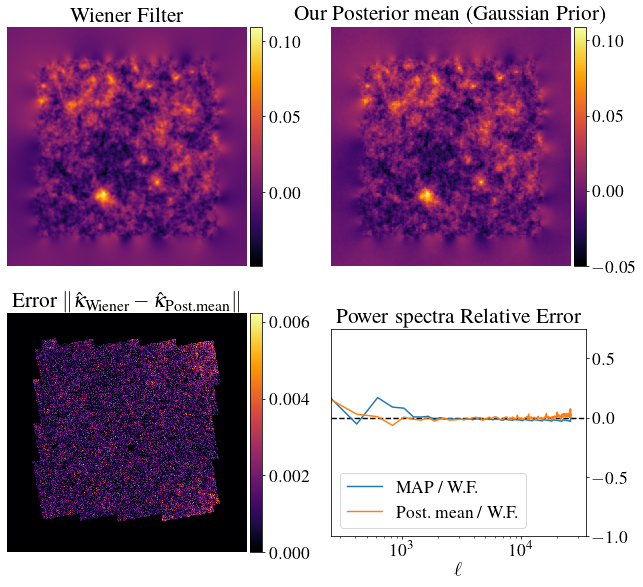

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

kwargs = dict(cmap='inferno')
fontsize=dict(fontsize=22)

fsize = 18

#_ = plt.figure(figsize=(10,10))
fig, ax = plt.subplots(2,2, figsize=(9,9), dpi=70)

im = ax[0,0].imshow(wf_e[::-1, ::-1], **kwargs)
ax[0,0].set_title('Wiener Filter', **fontsize)
ax[0,0].axis('off')#, colorbar()
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=fsize)

#im = ax[0,1].imshow(nsm_map, interpolation='None', **kwargs)
im = ax[0,1].imshow(sol.mean(0)[::-1, ::-1], interpolation='None', **kwargs)
#ax[0,1].set_title('Score-based MAP (Gaussian Prior)', **fontsize)
ax[0,1].set_title('Our Posterior mean (Gaussian Prior)', **fontsize)
ax[0,1].axis('off')#,  plt.colorbar()
ax[0,1].tick_params(axis='x', labelsize=14)
ax[0,1].tick_params(axis='y', labelsize=14)
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=fsize)

#im = ax[1,0].imshow(mask*np.abs(wf_e - nsm_map)[::-1, ::-1], interpolation='None', **kwargs)
im = ax[1,0].imshow(mask*np.abs(wf_e - sol.mean(0)), interpolation='None', **kwargs)
ax[1,0].set_title(r'Error $\|\hat{\kappa}_\mathrm{Wiener}-\hat{\kappa}_\mathrm{Post. mean}\|$', **fontsize)
#ax[1,0].set_title(r'Error $\|\hat{\kappa}_{wiener}-\hat{\kappa}_\mathrm{Post. mean}\|$', **fontsize)
ax[1,0].axis('off')#,  plt.colorbar()
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=fsize)

#ps_ratio = ps_wiener/ps_nsm_map
ps_ratio = (ps_nsm_map-ps_wiener)/ps_wiener
#ps_ratio_mean = ps_wiener/ps_mean
ps_ratio_mean = (ps_mean-ps_wiener)/ps_wiener
ps_ratio_mean_prev = (ps_meanprev-ps_wiener)/ps_wiener
ax[1,1].set_title('Power spectra Relative Error', **fontsize)
ax[1,1].set_aspect('equal')
#ax[1,1].loglog(k_wiener[:128], ps_ratio[:128], label='MAP / Wiener Filter')
#ax[1,1].loglog(k_wiener[:128], ps_ratio_mean[:128], label='Mean Posterior / Wiener Filter')
ax[1,1].plot(k_wiener[1:128], ps_ratio[1:128], label='MAP / W.F.', zorder=1)
#ax[1,1].plot(k_wiener[1:128], ps_ratio_mean[1:128], label=r'Post.mean ($10^{-4}$) / W.F.', color='red', zorder=1)
#ax[1,1].plot(k_wiener[1:128], ps_ratio_mean_prev[1:128], label=r'Post. mean($10^{-3}$) / W.F.', color='tab:orange', zorder=1)
ax[1,1].plot(k_wiener[1:128], ps_ratio_mean_prev[1:128], label=r'Post. mean / W.F.', color='tab:orange', zorder=1)
ax[1,1].set_xscale('log')
#ax[1,1].set_ylim([1e-1, 2.])
xmin = 2.5e2
xmax = 3.5e4
ymin = -1.
ymax = .75
ax[1,1].set_xlim([xmin, xmax])
ax[1,1].set_ylim([ymin, ymax])
#ax[1,1].loglog(ps_wiener/ps_nsm_mean, '--', label='Wiener Filter / Posterior Mean')
#ax[1,1].set_ylim([1e-1, 1e1])
ax[1,1].legend(fontsize=fsize, loc=3)
ax[1,1].yaxis.tick_right()
#xmin, xmax = ax[1,1].get_xlim()

ax[1,1].hlines(0., xmin, xmax, linestyle='--', color='k', zorder=0)
#ax[1,1].add_patch(Rectangle((1e4, ymin), xmax, (ymax)-(ymin), color='k', alpha=0.1))
ax[1,1].set_xlabel(r'$\ell$', fontsize=fsize+2)
ax[1,1].tick_params(axis='x', labelsize=fsize)
ax[1,1].tick_params(axis='y', labelsize=fsize)

plt.tight_layout(pad=0., w_pad=2.3, h_pad=-3.)

plt.savefig('plots/gaussian-fig-5.pdf')

In [38]:
solprev.shape

(2101, 360, 360)

In [39]:
np.save('res/wf_e.npy', wf_e)

In [40]:
ell, ps_noise = spectral.measure_power_spectrum(0.148 * np.random.randn(360,360), pixel_size)
k_map, ps_map = spectral.measure_power_spectrum(kp, pixel_size)

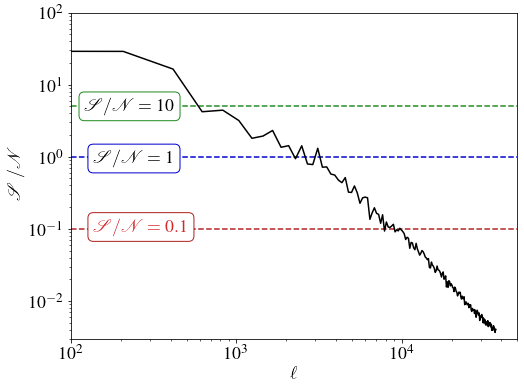

In [41]:
f, ax = plt.subplots(1,1, figsize=(8,6))

left, right = (1e2, 5e4)
ax.set_xlim([left, right])

r = dict(xmin=left, xmax=right)

ax.hlines(y=5, **r, color='forestgreen', linestyle='--')
props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='forestgreen')
ax.text(x=0.03, y=0.74, s=r'$\mathcal{S/N}=10$', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

ax.hlines(y=1, **r, color='mediumblue', linestyle='--')
props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='mediumblue')
ax.text(x=0.05, y=0.58, s=r'$\mathcal{S/N}=1$', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

ax.hlines(y=0.1, **r, color='firebrick', linestyle='--')
props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='firebrick')
ax.text(x=0.05, y=0.37, s=r'$\mathcal{S/N}=0.1$', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props, color='tab:red')

ax.loglog(ell, ps_map/ps_noise, linewidth=1.5, color='k')

left, right = (1e2, 5e4)
ax.set_xlim([left, right])
ax.set_ylim([3*1e-3, 1e2])
ax.set_xlabel(r'$\ell$', fontsize=18)
ax.set_ylabel(r'$\mathcal{S~/N}$', fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

savefig('plots/snr.pdf')

Average of Gaussian realisations